# `fb-Prophet` Machine Learning Model Documentation


**`fbprophet`** in this notebook we are implementing the fb prophet Model

## Key Parameters
        
- **Growth Detection:** Detecting growth using custom method Ex: linear or Logistic  

- **Automatic Changepoint Detection:** Using Pelt algo to detect changepoints.

- **Generating Ramadan Days:** Using a Hijri Converter fn to generate Ramadan Days between two years

- **Seasonality Modeling:** Experimenting various types of seasonality, such as yearly, weekly, and daily patterns and Ramadan.

- **Holidays and Special Events:** Adding Ramadan as a special Holiday to include the Ramadan effect.

- **Additional Regressors:** 
- **Multiplicative Seasonality:** specify custom trend components
- **Outliers:** Using traditional stat method 
- **Cross Validation:** 
- **Hyperparameter tuning:** 
- **Generate future dates:** 


### Installation Usage: Install the required dependencies:
To use `fbprophet`, you need following libraries.
- pip install Prophet
- pip install pelt
- pip install ruptures
- pip install math
- pip install holidays
- pip install hijri_converter

# **Parameters**
### ******Input Parameters from Interface******

### *****Model Parameters: Parameters passed inside the model itself Directly*****

In [533]:
# Growth mode: 'linear', 'logistic',  'flat', None (determined by user or method)

growth=None # if this is none then growth will be determined by the user else it will be determined by our method if determineGrowth is true
determineGrowth=True # If True, growth is determined by our method; else, by the user

#If ,mc_samples=0 then MAP estimation is used
mcmc_samples =None # Number of samples for MCMC (Markov Chain Monte Carlo)

#Interval_width: Sets the width of the uncertainty intervals provided in the forecast. A larger `interval_width` (e.g., 0.95) provides wider intervals, reflecting increased uncertainty.
interval_width =None # Uncertainty in the trend

#Seasonality mode: 'multiplicative' or 'additive'
#seasonality_mode is proportional to the baseline, allowing for variations in magnitude with changes in the overall level of the time series.
#Can detect with seasonality_mode='multiplicative' or 'additive' with Growth function as 'linear' or 'logistic', Linear will be additive and logistic will be multiplicative:Need experimentation

seasonality_mode='multiplicative'

#We are using inbuilt option and weekends are not included in this, but later we might use custom holidays
customholidays_df = pd.DataFrame({'ds': [], 'holiday': []})
holidays_prior_scale =None       #  parameter that determines the degree to which the holiday components are allowed to impact the forecast. If this is set to zero, then the holiday effects are not used. Increasing it will allow the holidays to have more effect. Default is 10, which provides very little regularization. Low Value: 0.05 , High Value : 10 or higher

# Yearly, Monthly,Ramadan,Weekend days seasonality
yearly_seasonality=False # Default is 20
weekly_seasonality=False
daily_seasonality=False

#changepoints
#changepoints: Pelt is generating better results
changepoint_prior_scale  =None     #How flexible the changepoints are allowed to be, high it will be more flexible, can lead to overfitting also (ex: 10,30)
n_changepoints =None               #This effects the results. Pelt is handling better
changepoint_range =None            #By default its good

#### ******Parameters as a custom Parameters: Ex: Additional Seasonality******

In [534]:
#Additional  Seasonality regressors

#Custom holidays
country_name='SA' # Country Code  (ISO 3166-2) for holidayss


yearly_add_seasonality=False
yearly_season_period=None
yearly_season_fourier_order=None

quarterly_add_seasonality=False
quarterly_season_period=None
quarterly_season_fourier_order=None

monthly_add_seasonality=False
monthly_season_period=None
monthly_season_fourier_order=None

# Weekend days (0-6, Mon-Sun)
weekend_days = [4]  # 4 is Friday

Weekend_add_seasonality=False
weekendDaysCount=1
Weekends_fourier_order=15

WorkingDays_add_seasonality=False
workingDaysCount=6
WorkingDays_fourier_order=5

ramadan_add_seasonality=True
ramadan_period=29.33
ramadan_fourier_order=10


#### ******Parameters used in other calc, other than the model******

In [535]:
# Penalty sensitivity for PELT algorithm: 'High', 'Medium', 'Low' : Used to determine the penalty value for the PELT algo which is used for changepoint detection
PenaltySensitivity ="High"  

# Model type for changepoint detection: 'l1' (linear 1), 'l2' (linear 2), 'rbf' (radial basis function)
pltModelType = "l2"  # "l2", "rbf"


detectoutliers =False # If True, outliers are detected and removed from the data else outliers are not detected and not removed from the data

#IQR stands for Interquartile Range, which is a measure of statistical dispersion of data
#IQR Range for outlier detection (1.5 is default) 3 is too high ,  upper_bound = Q3 + IQRRange * IQR and lower_bound = Q1 - IQRRange * IQR 

IQRRange=1.5 

# ****Prophet Algorithm****

#### ******Input Parameters Processed and Passed inside the Model directly******
#### ****Processing Parameters****

In [536]:
# Create a Prophet model with flexible parameters
prophet_params = {
    'growth': growth if determineGrowth else None,
    'mcmc_samples': mcmc_samples,
    'interval_width': interval_width,
    'seasonality_mode': seasonality_mode,
    'custom_holidays': customholidays_df if not customholidays_df.empty else None,
    'holidays_prior_scale': holidays_prior_scale,
    'yearly_seasonality': yearly_seasonality,
    'weekly_seasonality': weekly_seasonality,
    'daily_seasonality': daily_seasonality,
    'changepoint_prior_scale': changepoint_prior_scale,
    'n_changepoints': n_changepoints,
    'changepoint_range': changepoint_range,
}
print(prophet_params)
# Remove parameters with value None
prophet_params = {key: value for key, value in prophet_params.items() if value is not None}
print(prophet_params)


{'growth': None, 'mcmc_samples': None, 'interval_width': None, 'seasonality_mode': 'multiplicative', 'custom_holidays': None, 'holidays_prior_scale': None, 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'changepoint_prior_scale': None, 'n_changepoints': None, 'changepoint_range': None}
{'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False}


### ****Importing Libraries****

In [537]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import math
import ruptures as rpt
import warnings
import holidays
from hijri_converter import convert
from datetime import date,datetime, timedelta
from prophet.diagnostics import performance_metrics, cross_validation
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

warnings.filterwarnings("ignore")

### ****Importing the dataset****

In [538]:
# Load and prepare the data for Prophet
df = pd.read_csv('/home/ajaz/DemandForecasting/Data/data.csv')
data = df.rename(columns={'TransactionDate': 'ds', 'GroupCostPrice': 'y'})  # Rename columns for Prophet compatibility
data = data[['ds', 'y']]
data['ds']=pd.to_datetime(data['ds'])

# # Define the start and end dates for filtering covid  
covid_start_date = '2020-03-02'
covid_end_date = '2020-06-21'

# Filter the data frame to include only the year 2023
#data = data[data['ds'].dt.year ==2023]

# Get the first and last dates of the filtered data
start_date = pd.to_datetime( data['ds'].iloc[0])
end_date = pd.to_datetime( data['ds'].iloc[-1])

# Extract the first 30 days of the data
first_30Days = data.iloc[0:30]

#data.head(2)

### Detecting Growth  Parameter

The growth was determined by our method
growth type is linear with window size 525


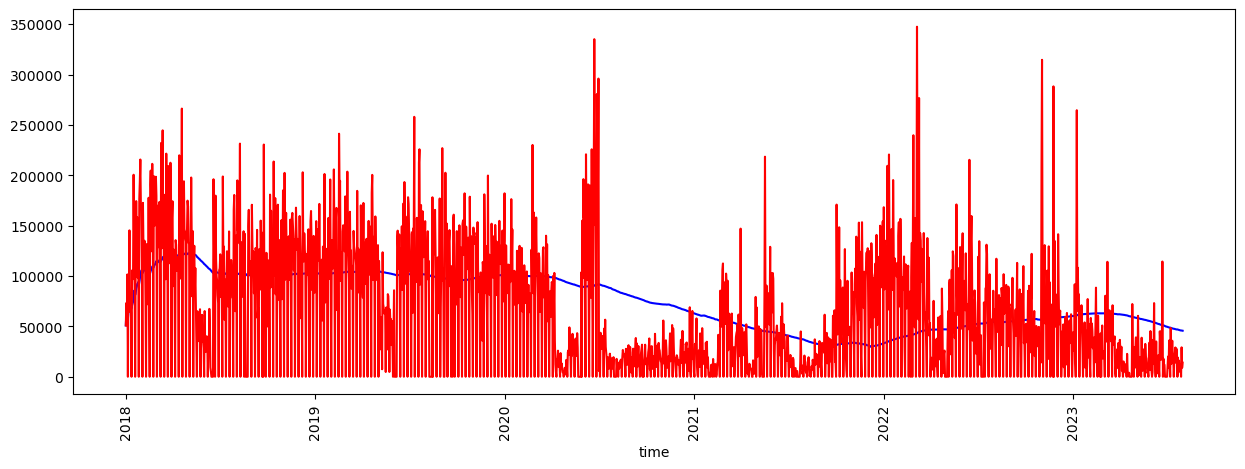

In [539]:
# Function to decide whether data['y'] is logistic or linear
def get_smooth_data(df, date_column, value_column, window_size=30):
    """
    Smooths the data in the value_column using a rolling mean.

    Parameters:
    df (DataFrame): The input DataFrame with a date and a value column.
    date_column (str): The name of the column containing date information.
    value_column (str): The name of the column containing the data to smooth.
    window_size (int): The size of the rolling window to use for smoothing.

    Returns:
    DataFrame: A new DataFrame with an additional column 'smoothed_value'.
    """
    
    df_copy = df.copy()

    # Ensure the date column is in datetime format
    df_copy[date_column] = pd.to_datetime(df_copy[date_column])
    
    # Set the date column as the index for rolling
    df_copy.set_index(date_column, inplace=True)
    
    # Calculate the rolling mean
    df_copy[value_column] = df_copy[value_column].rolling(window=window_size, min_periods=1).mean()
    
    # Reset the index to return to the original format
    df_copy.reset_index(inplace=True)
    
    return df_copy


def logistic_function(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

# Function to detect trend type by passing the dataframe, date column and value column names
def detect_trend(df, date_column, value_column):
    df['date_ordinal'] = pd.to_datetime(df[date_column]).apply(lambda date: date.toordinal())

    # Linear Fit
    linear_model = LinearRegression()
    linear_model.fit(df[['date_ordinal']], df[value_column])
    linear_r_squared = linear_model.score(df[['date_ordinal']], df[value_column])
    #print(f"Linear R-squared: {linear_r_squared}")

    if linear_r_squared > 0.70:  # Adjusted threshold
        return 'linear'
    
    # Logistic Fit
    try:
        popt, _ = curve_fit(logistic_function, df['date_ordinal'], df[value_column], maxfev=10000)
        logistic_r_squared = 1 - np.var(np.array(df[value_column]) - logistic_function(df['date_ordinal'], *popt)) / np.var(df[value_column])
        #print(f"Logistic R-squared: {logistic_r_squared}")

        if logistic_r_squared > 0.70:  # Adjusted threshold
            return 'logistic'
    except RuntimeError as e:
        print(f"Error in logistic fit: {e}")

    # Flat Trend
    std_dev = df[value_column].std()
    mean_val = df[value_column].mean()
    #print(f"Standard Deviation: {std_dev}, Mean: {mean_val}")

    if std_dev < (mean_val * 0.3):  # Adjusted threshold
        return 'flat'

    return 'Unknown'

# loop throgh number from 30 to 100 and find the best window size
#window_size=30
def get_growth_by_smoothing_data(data):
    '''
    This function will loop through the window size from 1 to len(data) and find the best window size
    the return value will be growth type and the smoothed data and the window size
    '''
    max_window_size=int(len(data) )
    for window_size in range(1,max_window_size):
        smooth_df=get_smooth_data(data,'ds','y',window_size=window_size)
        newGroth= detect_trend(smooth_df,'ds','y')
        if newGroth == 'Unknown':
            continue
        else:
            return newGroth, smooth_df, window_size
    return 'Unknown', smooth_df, window_size

# if the user passed determineGrowth as true then we will determine the growth type by our method
# and if didn't pass true then we will check if the user passed growth type or not

# Detect growth pattern
if determineGrowth == True:
    growth , smooth_df , window_size= get_growth_by_smoothing_data(data)
    print ("The growth was determined by our method")
    print('growth type is ' + growth + ' with window size ' + str(window_size))
    plt.plot(smooth_df['ds'], smooth_df['y'], linestyle = 'solid',color='blue')
else:
    if growth is None:
        # throw exception indicates that we need to pass growth type or determineGrowth should be true
        raise Exception("You should pass growth type one of these values ( linear , logistic or flat) or determineGrowth should be true" )
    else:
        print ("The growth was determined by the user")
        print( 'growth type is ' + growth )


# if the growth type is not flat or logistic or linear then we will throw exception
if growth not in ['flat','logistic','linear']:
    raise Exception("growth type should be one of these values ( linear , logistic or flat)" )

plt.plot(data['ds'], data['y'], linestyle = 'solid',color='red')

# a line plot like a trend over the time monthly
plt.xticks(rotation=90)
plt.xlabel('time')
fig = plt.gcf()
fig.set_size_inches(15, 5)

### Detecting Change points Parameter using PELT Algo

PELT algorithm is utilized for changepoint detection in the trained data

,ds,y
0,2018-01-01,50930.49
1,2018-01-02,73204.65


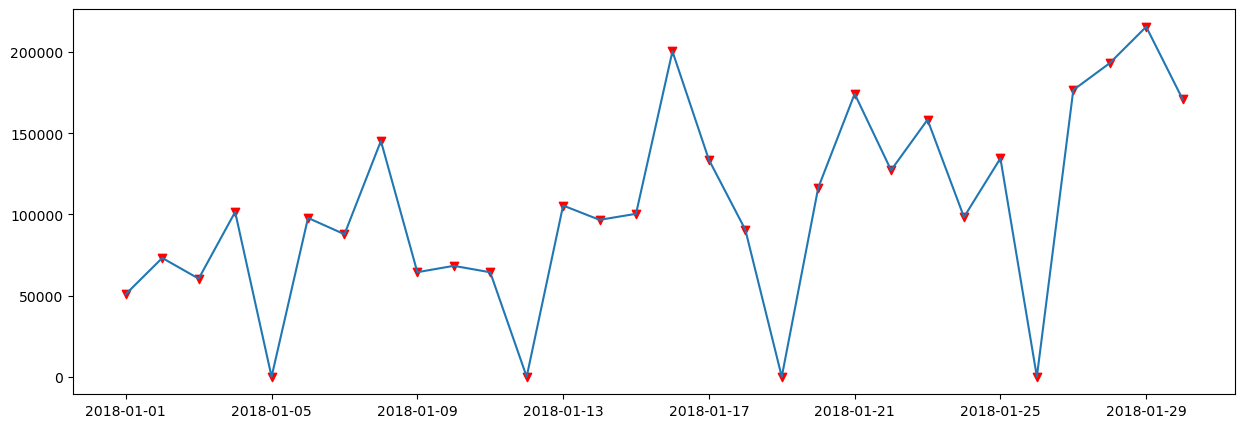

In [540]:
# Define a function to calculate the penalty for changepoint detection based on sensitivity level and predefined coefficients

def calculate_penalty(data, sensitivity, cal=[6, 3, 1.5]):
    if sensitivity == "Low":
        return cal[0] * math.log(len(data))
    elif sensitivity == "Medium":
        return cal[1] * math.log(len(data))
    elif sensitivity == "High":
        return cal[2] * math.log(len(data))

peltdata = data['y'].values
# You can choose between "l1" and "l2" cost functions

algo = rpt.Pelt(model=pltModelType, min_size=1, jump=1).fit(peltdata)
penalty= calculate_penalty(peltdata, PenaltySensitivity)
result = algo.predict(pen=3)

changepointDates=[]
for index in result:
    a=data.iloc[index-1]['ds']
    changepointDates.append(a)

changepointDates=pd.DataFrame(changepointDates, columns=['ds'])
changepointDates['ds'] = pd.to_datetime(changepointDates['ds'])

changepoints=changepointDates['ds']
daysInChangepoints=first_30Days.loc[first_30Days['ds'].isin(changepoints)]

plt.plot(first_30Days['ds'],first_30Days['y'] )
plt.scatter(daysInChangepoints['ds'],daysInChangepoints['y'], marker='v', color='r')
fig = plt.gcf()
fig.set_size_inches(15, 5)

daysInChangepoints.head(2)
#holidays=holidays
#changepointDates.head(2)

# Outlier
##### Original Data Filtered by the Outliers

In [541]:
if detectoutliers:
    #plot like a fot not as a line for data['ds'], data['y']  ds on x axis and y on y axis, dont join the line only the points
    plt.scatter(data['ds'], data['y'], linestyle = 'solid',color='red')
    #increase the width of the plot
    fig = plt.gcf()
    fig.set_size_inches(15, 5)

    print(data['y'].describe())
    Q1 = data['y'].quantile(0.25)
    Q3 = data['y'].quantile(0.75)
    QCustom99= data['y'].quantile(0.99)

    IQR = Q3 - Q1

    lower_bound = Q1 - IQRRange * IQR
    upper_bound = Q3 + IQRRange * IQR
    soutliers = data[((data['y'] < lower_bound) | (data['y'] > upper_bound))]

    # Identifying outliers
    outliers = data[((data['y'] < lower_bound) | (data['y'] > upper_bound))]

    # Replace outlier values with the mean
    data.loc[outliers.index, 'y'] = data['y'].mean()


    plt.scatter(data['ds'], data['y'], linestyle = 'solid',color='green')
    #plt.scatter(data['ds'], data['y'], linestyle = 'solid',color='red')


    print('CustomQuartile99 < 99% : ' + str(QCustom99))
    print('IQR : ' + str(IQR))

    print('Number of Outliers :' + str(len(soutliers)))
    print('Number of rows in data : ' + str(len(data)))
    print('lower_bound : ' + str(lower_bound))
    print('upper_bound : ' + str(upper_bound))
    print(outliers)



## Generate Ramadan Dates

The function generate_ramadan_dates_df(start_year, end_year) generates a DataFrame of Ramadan dates in the Gregorian calendar for a given range of years.

In [542]:
def generate_ramadan_dates_df(start_year, end_year):
    ramadan_dates = []

    for year in range(start_year, end_year + 1):
        # The Umm al-Qura calendar uses Hijri dates for Islamic months
        hijri_year_start = convert.Gregorian(year, 1, 1).to_hijri()
        hijri_year_end = convert.Gregorian(year, 12, 30).to_hijri()

        for day in range(1, 30):  # Assuming Ramadan lasts for 29 or 30 days
            # Find the date of Ramadan in the Hijri calendar
            ramadan_date = convert.Hijri(hijri_year_start.year, 9, day).to_gregorian()

            # Append the date to the list
            ramadan_dates.append(ramadan_date)

    # Create a DataFrame with a column named 'ramadan_dates'
    ramadan_df = pd.DataFrame({'ds': ramadan_dates})
    return ramadan_df

In [543]:
start_year = start_date.year
end_year = end_date.year
ramadan_df = generate_ramadan_dates_df(start_year, end_year)

## Generate the Weekend Days Param

In [544]:
def generate_weekends(start_date, end_date, weekend_days):
    '''
    This function will generate weekends dataframe with ds and holiday columns
    Parameters : 
    start_date : start date of the data of type datetime
    end_date : end date of the data of type datetime
    weekend_days : list of weekend days ex: [4] for Friday
    return : weekends dataframe with ds and holiday columns
    '''
    weekends = []

    current_date = start_date

    while current_date <= end_date:
        # Check if the current date is a weekend
        if current_date.weekday() in weekend_days:
            weekends.append(current_date)
        current_date += timedelta(days=1)

    # Create a DataFrame with day names and dates
    weekend_df = {'ds': weekends,
                  'holiday': [day.strftime('%A') for day in weekends]}

    df_weekends = pd.DataFrame(weekend_df)
    return df_weekends

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


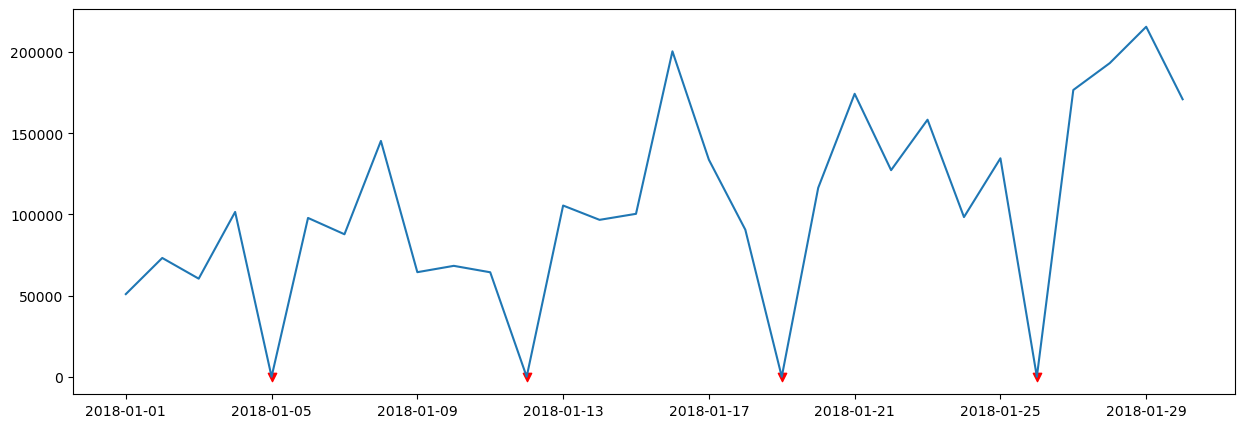

In [545]:
print(type(start_date))
df_weekends = generate_weekends(start_date, end_date, weekend_days)
data['is_weekend'] = data['ds'].isin(df_weekends['ds']).astype(int)
data['is_weekday'] = (data['is_weekend'] == 0).astype(int)

weekendDaysCount= len(weekend_days)
workingDaysCount= 7 - weekendDaysCount


first_30Days['is_weekend'] = first_30Days['ds'].isin(df_weekends['ds']).astype(int)

onlyWeekends= first_30Days[data['is_weekend']==1]

plt.plot(first_30Days['ds'],first_30Days['y'])
plt.scatter(onlyWeekends['ds'],onlyWeekends['y'], marker='v', color='r')
#increase the width of the plot
fig = plt.gcf()
fig.set_size_inches(15, 5)

#### Carrying Capacity Param

In [546]:
# Define a percentile value (e.g., 99th percentile)
percentile_value = 99

# Calculate the specified percentile for the cap
cap = (np.percentile(data['y'], percentile_value)) * 1.5

# Define a lower percentile value (e.g., 5th percentile) for the floor
percentile_floor = 5

# Calculate the specified percentile for the floor
floor = np.percentile(data['y'], percentile_floor)

#print (prophet_data[prophet_data['y'] == 0])

#prophet_data['cap']=cap
#prophet_data['floor']=floor 

#### Adding  Ramadan dates in prophet Training Data

In [547]:
data['is_ramadan'] = data['ds'].isin(ramadan_df['ds']).astype(int)
prophet_data= data

# **Training Model**

#### ****Initialize the Model**** ####

In [548]:
# Create the Prophet model with the filtered parameters
prophetModel = Prophet(**prophet_params)

### ****Custom  Seasonalties****

In [549]:
#if the  passed condition is True or Not none then it  execute the below code
#Check the names of the variables from the variables

if country_name:
    prophetModel.add_country_holidays(country_name=country_name)

if yearly_add_seasonality:
    prophetModel.add_seasonality(name='yearly_season' ,period=yearly_season_period ,fourier_order=yearly_season_fourier_order )

if quarterly_add_seasonality:
    prophetModel.add_seasonality(name='quarterly_season' ,period=quarterly_season_period ,fourier_order=quarterly_season_fourier_order )

if monthly_add_seasonality:
    prophetModel.add_seasonality(name='monthly_season' ,period=monthly_season_period ,fourier_order=monthly_season_fourier_order )

if Weekend_add_seasonality:
    prophetModel.add_seasonality(name='Weekends_season' ,period=weekendDaysCount ,fourier_order=Weekends_fourier_order ,condition_name='is_weekend')

if WorkingDays_add_seasonality:
    prophetModel.add_seasonality(name='WorkingDays_season' ,period=workingDaysCount ,fourier_order=WorkingDays_fourier_order ,condition_name='is_weekday')

if ramadan_add_seasonality:
    prophetModel.add_seasonality(name='ramadan_season' ,period=ramadan_period ,fourier_order=ramadan_fourier_order ,condition_name='is_ramadan')

#### ****Fit the model to the data**** ####

In [550]:
metric=prophetModel.fit(prophet_data)

15:31:08 - cmdstanpy - INFO - Chain [1] start processing
15:31:09 - cmdstanpy - INFO - Chain [1] done processing


# Generate future Dataframe Dates

In [551]:
### Generate future dates

future_df = prophetModel.make_future_dataframe(periods=30)
firstdate=future_df['ds'].iloc[0]
lastdate=future_df['ds'].iloc[-1]
future_weekends = generate_weekends(firstdate, lastdate, weekend_days)

future_df['is_ramadan'] = future_df['ds'].isin(ramadan_df['ds']).astype(int)

#future_df['cap'] = cap
#future_df['floor'] = floor

# Add the 'holidays' column to the future DataFrame
#future_df['holidays'] = 0
#future_df.loc[future_df['ds'].isin(df_weekends['ds']), 'holidays'] = 1

future_df['is_weekend'] = future_df['ds'].isin(future_weekends['ds']).astype(int)
future_df['is_weekday'] = (future_df['is_weekend'] == 0).astype(int)

## ****Cross Validation****

Need to generate mape values to finally decide about the algorithm

In [552]:
df_cv = cross_validation(prophetModel, initial='730 days', period='180 days', horizon = '30 days')
df_p = performance_metrics(df_cv)
df_p

  0%|          | 0/8 [00:00<?, ?it/s]

15:31:09 - cmdstanpy - INFO - Chain [1] start processing
15:31:09 - cmdstanpy - INFO - Chain [1] done processing
15:31:09 - cmdstanpy - INFO - Chain [1] start processing
15:31:09 - cmdstanpy - INFO - Chain [1] done processing
15:31:09 - cmdstanpy - INFO - Chain [1] start processing
15:31:09 - cmdstanpy - INFO - Chain [1] done processing
15:31:10 - cmdstanpy - INFO - Chain [1] start processing
15:31:10 - cmdstanpy - INFO - Chain [1] done processing
15:31:10 - cmdstanpy - INFO - Chain [1] start processing
15:31:10 - cmdstanpy - INFO - Chain [1] done processing
15:31:10 - cmdstanpy - INFO - Chain [1] start processing
15:31:10 - cmdstanpy - INFO - Chain [1] done processing
15:31:10 - cmdstanpy - INFO - Chain [1] start processing
15:31:10 - cmdstanpy - INFO - Chain [1] done processing
15:31:11 - cmdstanpy - INFO - Chain [1] start processing
15:31:11 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mdape,smape,coverage
0,3 days,1.973093e+09,44419.509694,31869.464315,1.096163,0.963686,0.958333
1,4 days,2.146177e+09,46326.851133,32044.646428,1.843273,1.030589,0.958333
2,5 days,2.194257e+09,46842.900696,32086.208952,1.843273,1.084383,0.916667
3,6 days,4.299878e+09,65573.452216,44804.598775,1.336416,1.162749,0.833333
4,7 days,3.212160e+09,56675.917180,39345.000498,0.790488,1.050848,0.875000
5,8 days,3.231187e+09,56843.527501,39645.213307,0.663667,0.995454,0.875000
6,9 days,1.532358e+09,39145.338454,29891.684135,0.506482,0.844214,0.875000
7,10 days,1.509009e+09,38845.970943,28046.889303,0.476022,0.850175,0.833333
8,11 days,1.494164e+09,38654.413743,26995.054850,0.555003,0.888695,0.875000
9,12 days,1.883506e+09,43399.374507,30050.721655,0.524578,0.869898,0.916667


In [566]:
df_p = performance_metrics(df_cv)
#Mean MAPE across all horizons
mean_mape = np.mean(df_p['smape'])
# Median MAPE (more robust to outliers)
MAPEresult = np.median(df_p['smape'])
#format the variable as a percentage
mean_mape = "{:.2%}".format(mean_mape)
MAPEresult = "{:.2%}".format(MAPEresult)
#print("Median MAPE: " + str(MAPEresult))
print("Mean MAPE: " + str(mean_mape))

Mean MAPE: 90.36%


# Generate predictions

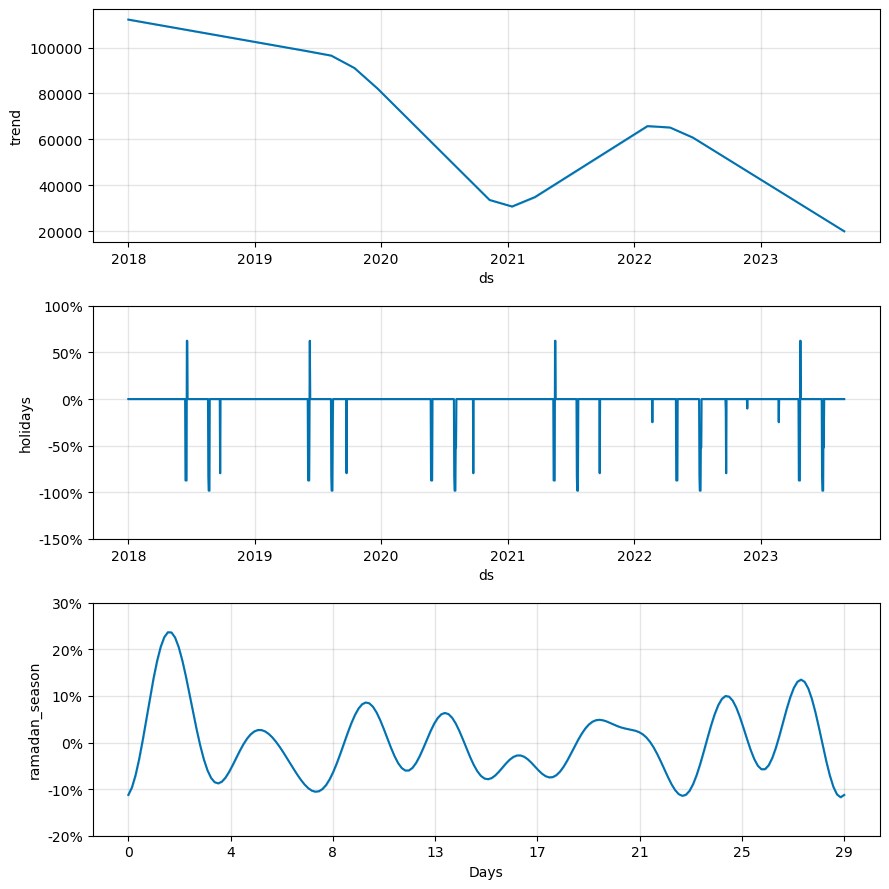

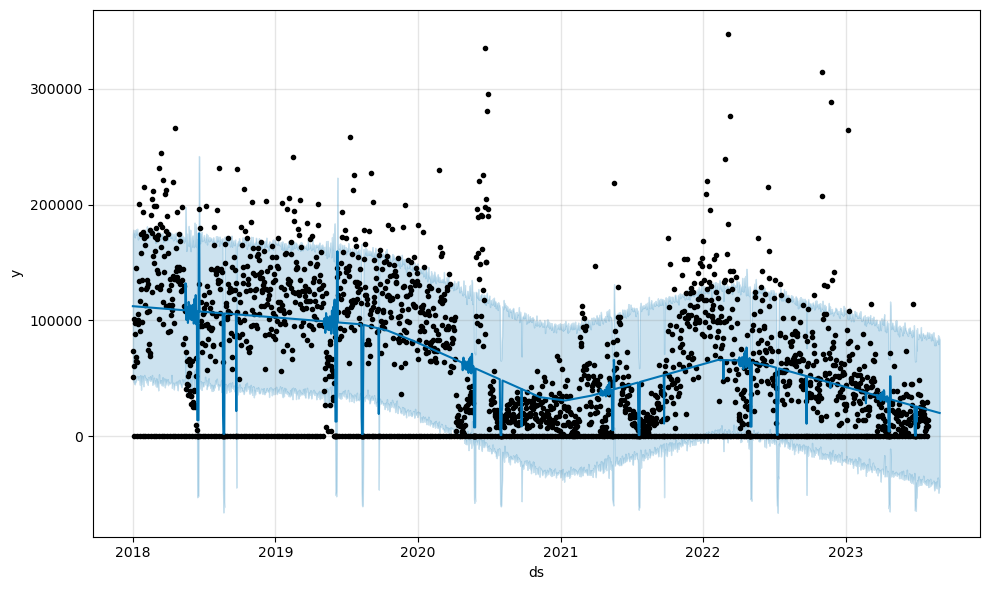

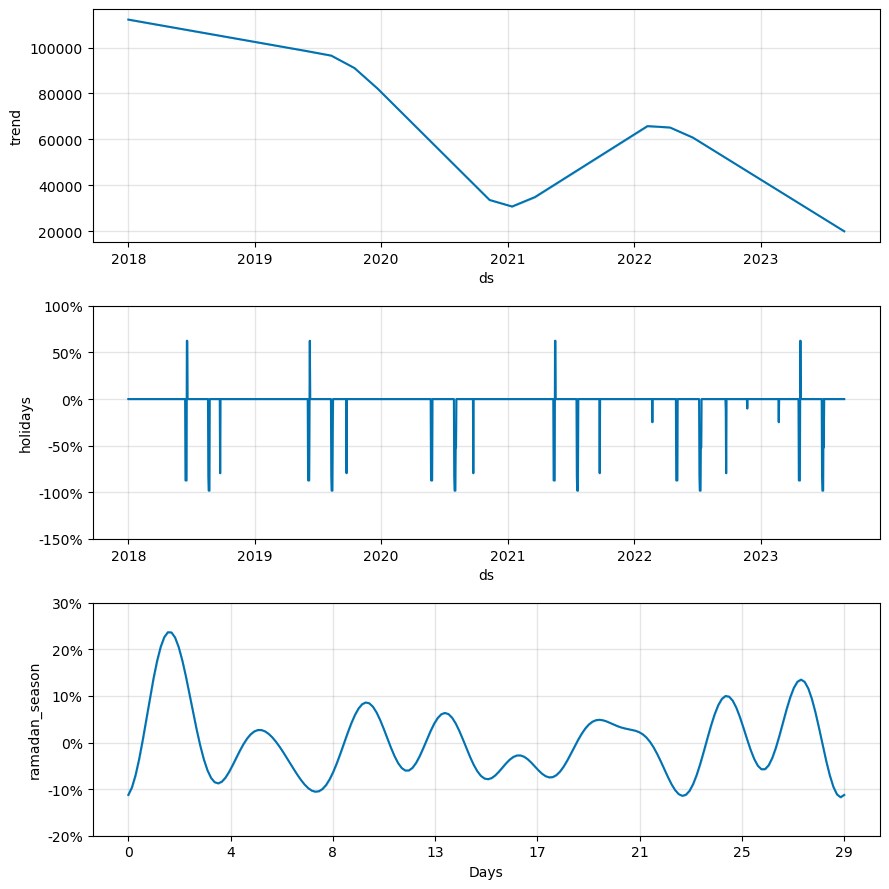

In [554]:
### Generate predictions
forecast = prophetModel.predict(future_df)

prophetModel.plot(forecast)
prophetModel.plot_components(forecast)

# Comparision of Actual And Predicted Data

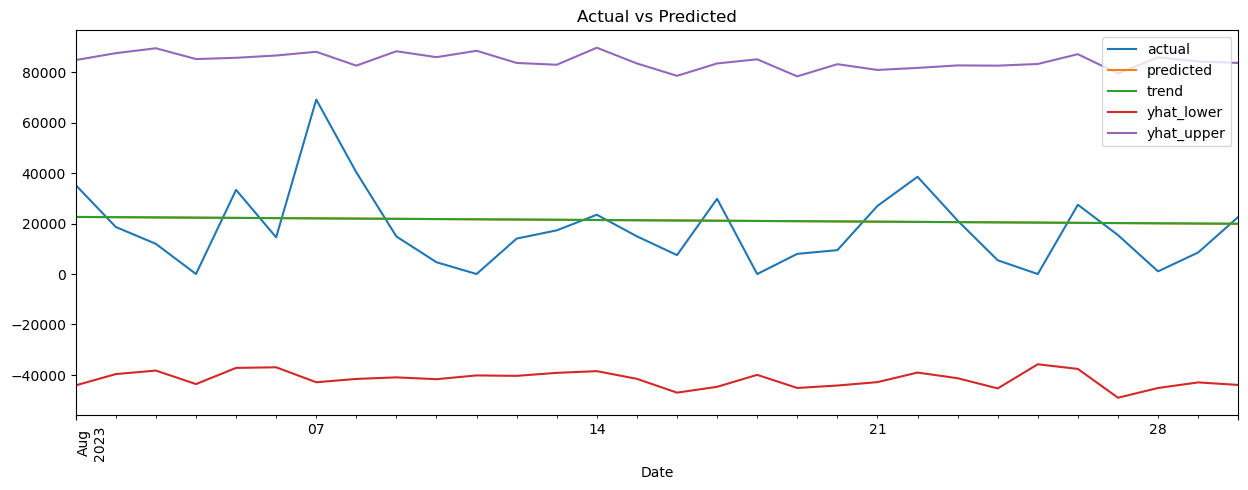

In [555]:
#Create comment for the following code
### Analyze and visualize results

#forecast.to_csv('/home/ajaz/DemandForecasting/Data/Output/forecast.csv')

actualdata = pd.read_csv('/home/ajaz/DemandForecasting/Data/actualdata.csv')
actualdata = actualdata.rename(columns={'TransactionDate': 'ds', 'GroupCostPrice': 'actual'})
actualdata['ds']=pd.to_datetime(actualdata['ds'])

#predicteddata =forecast[['ds', 'yhat']].tail(30)
forecast = forecast.rename(columns={'ds': 'ds', 'yhat': 'predicted'})
forecast['ds']=pd.to_datetime(forecast['ds'])

finaldata = pd.merge(actualdata,forecast.tail(30),on='ds')

finaldata.plot(x='ds', y=['actual', 'predicted','trend','yhat_lower','yhat_upper'], kind='line', title='Actual vs Predicted')
#show the day name x axis
plt.xticks(rotation=90)
plt.xlabel('Date')
fig = plt.gcf()
fig.set_size_inches(15, 5)

# print the rows with negative values 

#finaldata.to_csv('/home/ajaz/DemandForecasting/Data/final.csv')

In [556]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,A National Day,A National Day_lower,A National Day_upper,Arafat Day* (*estimated),...,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,ramadan_season,ramadan_season_lower,ramadan_season_upper,additive_terms,additive_terms_lower,additive_terms_upper,predicted
0,2018-01-01,112203.650632,48816.792538,173552.196252,112203.650632,112203.650632,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,112203.650632
1,2018-01-02,112177.103238,47050.983521,178337.110181,112177.103238,112177.103238,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,112177.103238
2,2018-01-03,112150.555844,51418.197910,175358.054776,112150.555844,112150.555844,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,112150.555844
3,2018-01-04,112124.008450,45118.037593,175460.424514,112124.008450,112124.008450,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,112124.008450
4,2018-01-05,112097.461055,45932.279586,176743.209923,112097.461055,112097.461055,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,112097.461055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2063,2023-08-26,20293.690763,-37619.276637,87149.189552,20252.705007,20350.300040,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20293.690763
2064,2023-08-27,20200.212182,-49031.639857,79496.665064,20151.020169,20268.018997,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20200.212182
2065,2023-08-28,20106.733602,-45173.506655,85902.980579,20044.919874,20189.538453,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20106.733602
2066,2023-08-29,20013.255022,-42963.791093,84264.497395,19942.226684,20114.519331,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20013.255022
